In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_excel("train.xlsx", sheet_name="Sheet1")

In [3]:
df["dt"] = pd.to_datetime(df["dt"])
df.set_index("dt", inplace=True)
df.dropna(inplace=True)

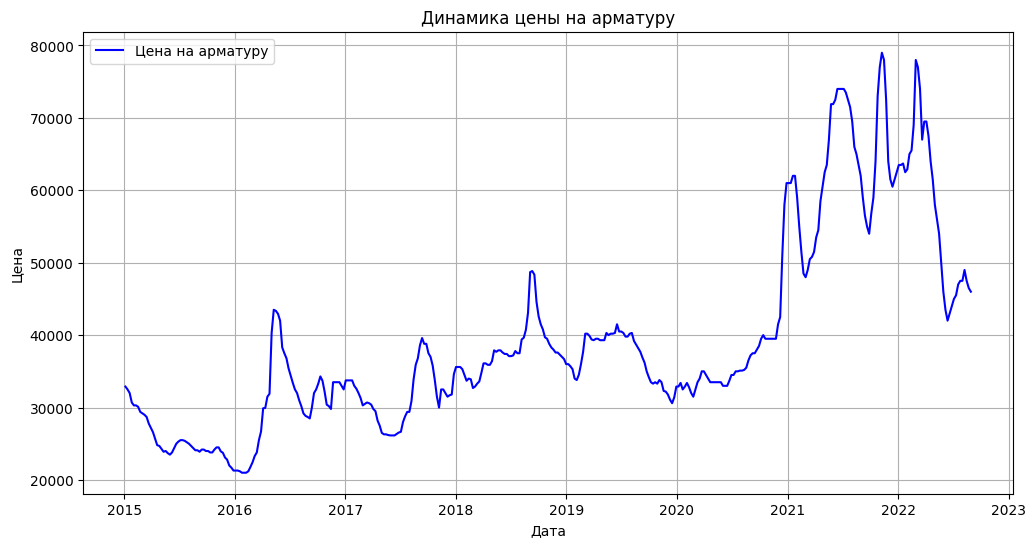

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Цена на арматуру", color="b")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Динамика цены на арматуру")
plt.legend()
plt.grid()
plt.show()

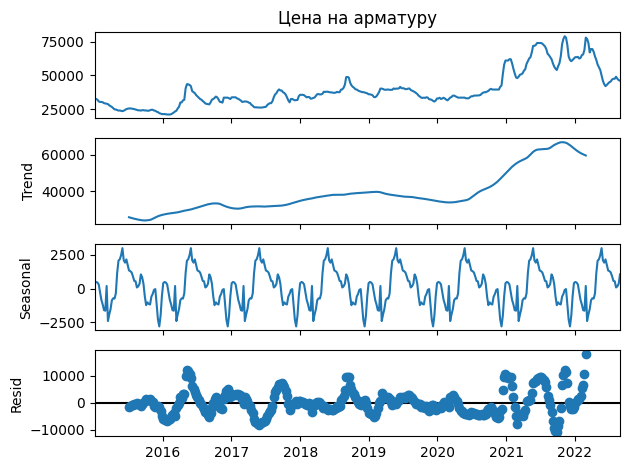

In [5]:
decomposition = seasonal_decompose(df["Цена на арматуру"], model="additive", period=52)
decomposition.plot()
plt.show()

In [6]:
df["lag_1"] = df["Цена на арматуру"].shift(1)
df["lag_2"] = df["Цена на арматуру"].shift(2)
df["lag_7"] = df["Цена на арматуру"].shift(7)
df["rolling_mean_7"] = df["Цена на арматуру"].rolling(window=7).mean()
df["year"] = df.index.year
df["month"] = df.index.month
df["week"] = df.index.isocalendar().week
df["day_of_week"] = df.index.dayofweek
df.dropna(inplace=True)

In [7]:
features = ["lag_1", "lag_2", "lag_7", "rolling_mean_7", "year", "month", "week", "day_of_week"]
target = "Цена на арматуру"
test_size = int(len(df) * 0.2)
X_train, y_train = df[features][:-test_size], df[target][:-test_size]
X_test, y_test = df[features][-test_size:], df[target][-test_size:]

In [8]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=30),
    #"XGBoost": XGBRegressor(n_estimators=150, learning_rate=0.40, random_state=30, enable_categorical=False),
    #"Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(alpha=0.)
}

results = {}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }


C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider i

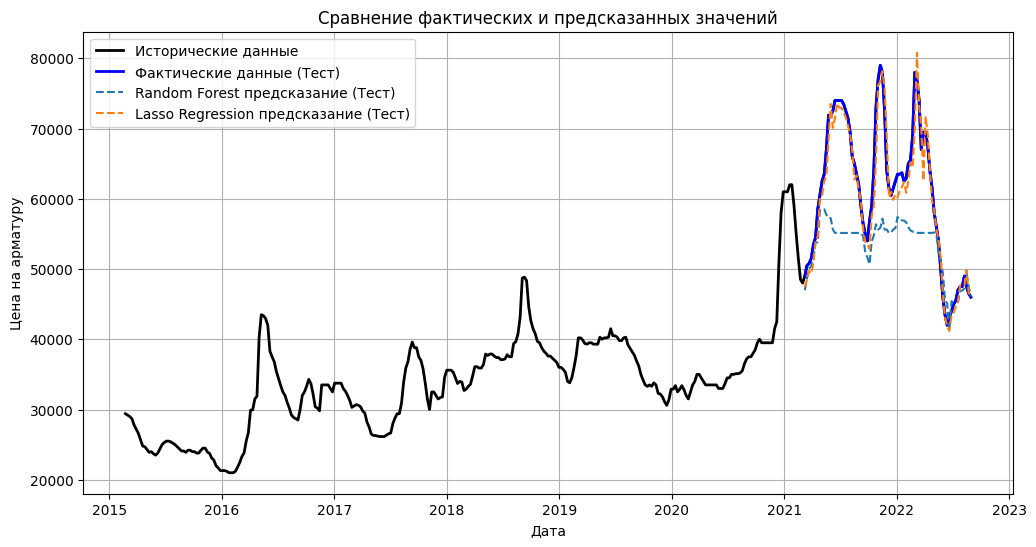

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[target], label="Исторические данные", color="black", linewidth=2)
plt.plot(y_test.index, y_test, label="Фактические данные (Тест)", color="blue", linewidth=2)
for name, y_pred in predictions.items():
    plt.plot(y_test.index, y_pred, linestyle="dashed", label=f"{name} предсказание (Тест)")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Сравнение фактических и предсказанных значений")
plt.legend()
plt.grid()
plt.show()

In [10]:
# results_df = pd.DataFrame(results).T
# plt.figure(figsize=(10, 5))
# results_df["R2"].plot(kind="bar", color=["blue", "green", "red", "purple"])
# plt.title("Сравнение моделей по R²")
# plt.ylabel("R² Score")
# plt.xlabel("Модель")
# plt.grid(axis="y")
# plt.show()


In [11]:
# print(results_df)


In [12]:
# window_size = 14
# futre_steps = 20
# X_iput = df[-window_size:].values.reshape(1,-1)
# future_pred = []
# for mod in [models]:
#     last_win = X_iput.copy()
#     model_pred = []

#     for i in range(futre_steps):
#         next_pr = mod

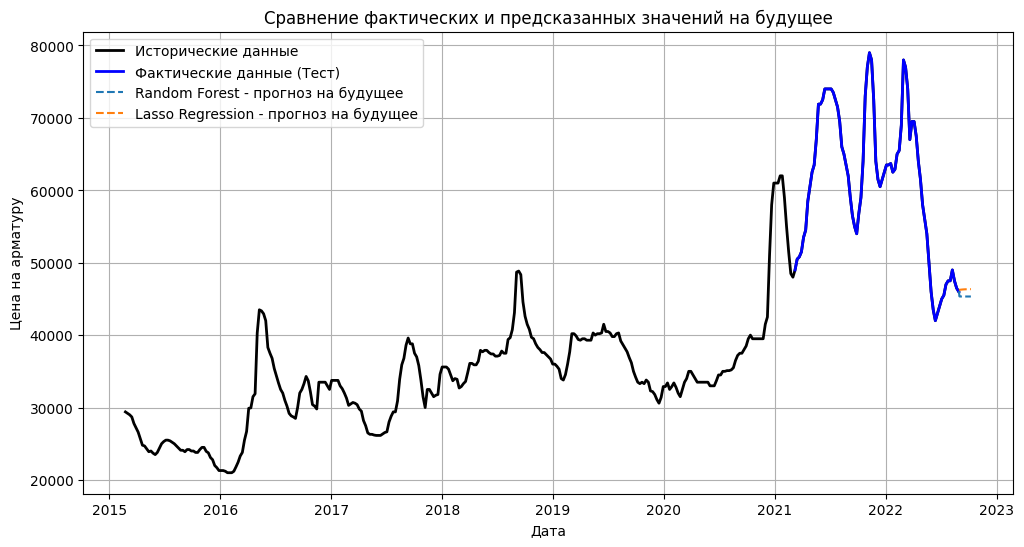

In [13]:

future_steps = 40

def predict_future(model, last_data, future_steps):
    model_preds = []
    for _ in range(future_steps):
        next_pred = model.predict(last_data)
        model_preds.append(next_pred[0])
        last_data = last_data.copy()
        last_data["lag_1"] = last_data["lag_1"].shift(-1, fill_value=next_pred[0])
        last_data["lag_2"] = last_data["lag_2"].shift(-1, fill_value=next_pred[0])
        last_data["lag_7"] = last_data["lag_7"].shift(-1, fill_value=next_pred[0])
        last_data["rolling_mean_7"] = last_data["rolling_mean_7"].shift(-1, fill_value=next_pred[0])
        last_data["year"] = last_data["year"].shift(-1, fill_value=last_data["year"].iloc[-1])
        last_data["month"] = last_data["month"].shift(-1, fill_value=last_data["month"].iloc[-1])
        last_data["week"] = last_data["week"].shift(-1, fill_value=last_data["week"].iloc[-1])
        last_data["day_of_week"] = last_data["day_of_week"].shift(-1, fill_value=last_data["day_of_week"].iloc[-1])

    return model_preds
future_predictions = {}
for name, model in models.items():
    last_window = X_test.iloc[-1:].copy()  
    future_preds = predict_future(model, last_window, future_steps)
    future_predictions[name] = future_preds

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Исторические данные", color="black", linewidth=2)
plt.plot(y_test.index, y_test, label="Фактические данные (Тест)", color="blue", linewidth=2)
future_index = pd.date_range(df.index[-1], periods=future_steps + 1, freq='D')[1:]
for name, future_preds in future_predictions.items():
    plt.plot(future_index, future_preds, linestyle="dashed", label=f"{name} - прогноз на будущее")

plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Сравнение фактических и предсказанных значений на будущее")
plt.legend()
plt.grid()
plt.show()
# print("Стартовое окно для прогноза:\n", last_window)



C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
C:\Users\josha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validat

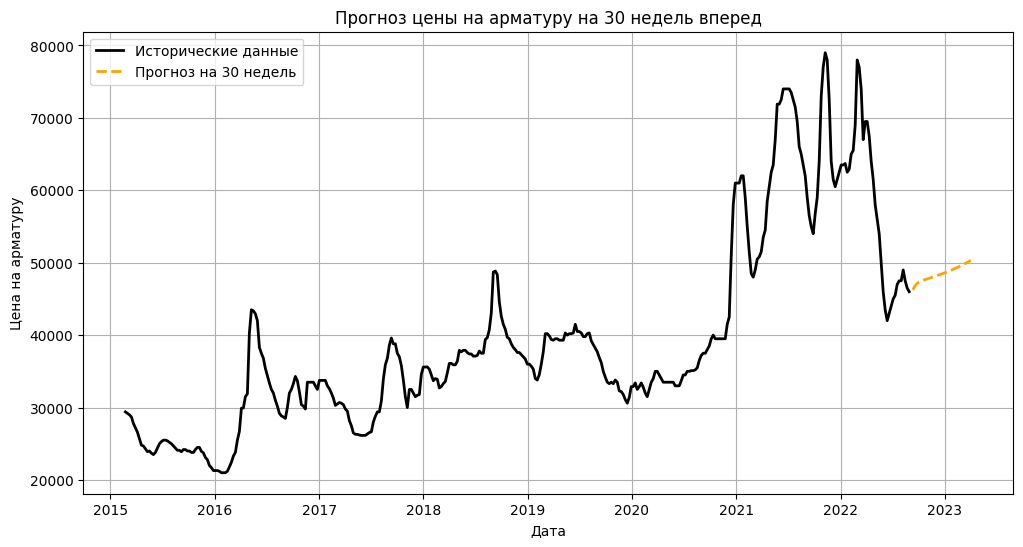

In [14]:
# Прогнозируем на 30 недель вперед
future_predictions = []
current_window = X_test.iloc[-1].copy()
# Прогноз на 30 недель вперед
for _ in range(30):
    # Преобразуем current_window в массив (1 строка с признаками)
    next_price = model.predict([current_window.values])[0]
    future_predictions.append(next_price)

    # Обновляем окно — сдвигаем лаги и добавляем новое значение
    current_window["lag_1"] = next_price
    current_window["lag_2"] = current_window["lag_1"]
    current_window["lag_7"] = current_window["lag_7"]  # можно заморочиться и сдвинуть глубже
    current_window["rolling_mean_7"] = (
        current_window["rolling_mean_7"] * 6 + next_price
    ) / 7

# Создаем даты на 30 недель вперед
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(weeks=1), periods=30, freq="W")

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(df.index, df[target], label="Исторические данные", color="black", linewidth=2)
plt.plot(future_dates, future_predictions, label="Прогноз на 30 недель", color="orange", linewidth=2, linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цены на арматуру на 30 недель вперед")
plt.legend()
plt.grid()
plt.show()



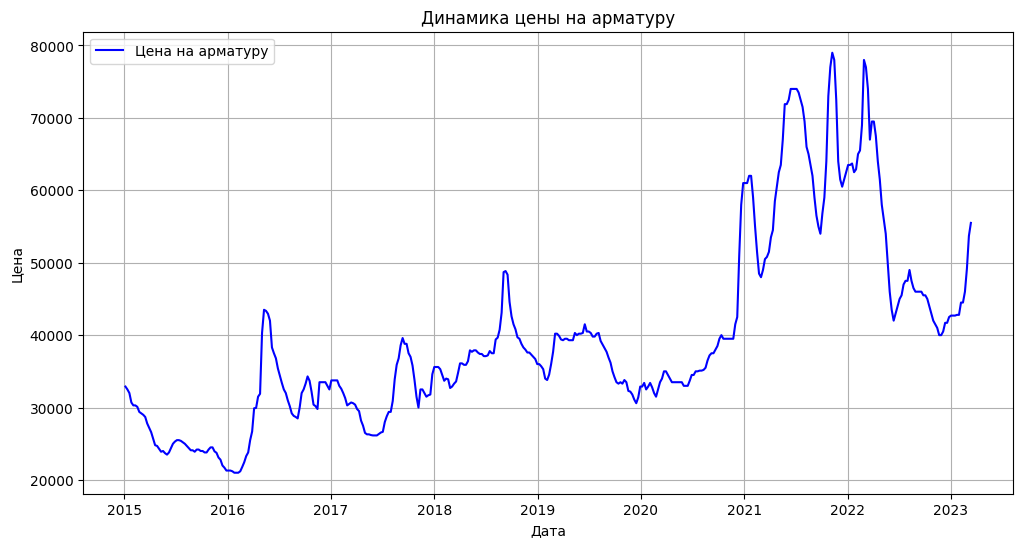

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

dfwerty = pd.read_excel("train.xlsx")
tswerty = pd.read_excel("test.xlsx")
haaah = pd.concat([dfwerty, tswerty], ignore_index=True)

haaah["dt"] = pd.to_datetime(haaah["dt"])

plt.figure(figsize=(12, 6))
plt.plot(haaah["dt"], haaah["Цена на арматуру"], label="Цена на арматуру", color="b")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Динамика цены на арматуру")
plt.legend()
plt.grid(True)
plt.show()
